In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import PIL.ImageOps as ImageOps
import PIL.Image as Image
from tqdm import tqdm

In [2]:
# Now we create the class names and store them in the labels.

class_names = ['Aloevera','Amla','Amruta_Balli','Arali','Ashoka','Ashwagandha','Avacado','Bamboo','Basale','Betel','Betel_Nut','Brahmi','Castor',
               'Curry_Leaf','Doddapatre','Ekka','Ganike','Gauva','Geranium',
               'Henna','Hibiscus','Honge','Insulin','Jasmine','Lemon','Lemon_grass',
               'Mango','Mint','Nagadali','Neem','Nithyapushpa','Nooni','Pappaya',
               'Pepper','Pomegranate','Raktachandini','Rose','Sapota','Tulasi',
               'Wood_sorel'

               ]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
nb_classes

40

In [4]:
def pre_process(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    return image

## Data load and Preprocess

In [5]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def load_data(dataset_path, test_size=0.2, random_state=42):
    images = []
    labels = []
    
    print("Loading images from {}".format(dataset_path))
    
    for folder in os.listdir(dataset_path):
        label = class_names_label[folder]
        for file in tqdm(os.listdir(os.path.join(dataset_path, folder))):
            img_path = os.path.join(dataset_path, folder, file)
            
            image = pre_process(img_path)
            
            images.append(image)
            labels.append(label)
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    return (train_images, train_labels), (test_images, test_labels)

dataset_path = "C:/Users/pavan/OneDrive/Desktop/Project/datasets/all_plant"
(train_images, train_labels), (test_images, test_labels) = load_data(dataset_path)


Loading images from C:/Users/pavan/OneDrive/Desktop/Project/datasets/all_plant


100%|██████████| 146/146 [00:03<00:00, 46.03it/s]


In [6]:
#(train_images, train_labels), (test_images, test_labels) = load_data()

In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

































In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 4756
Number of testing examples: 1189
Each image is of size: (224, 224)


## Scaling the Data

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualization

In [10]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [11]:
# A function to simply display only one random image
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

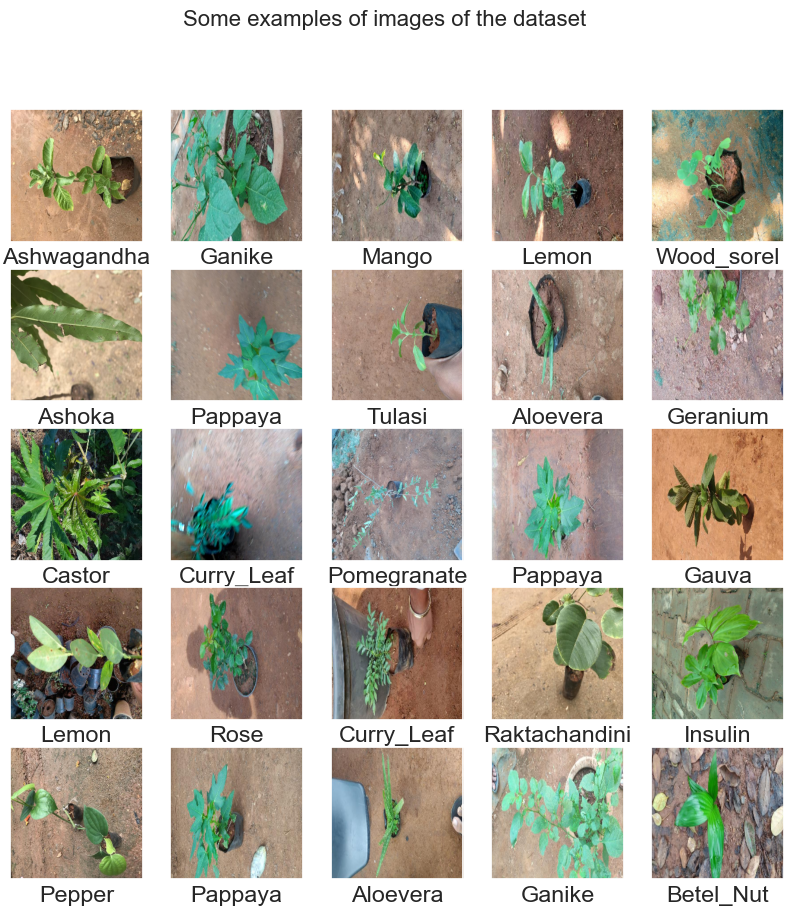

In [12]:
display_examples(class_names, train_images, train_labels)


## Model Creation

### MobileNetV2 is used as a feature extractor (include_top=False removes the default classification head).
### Global Average Pooling (pooling='avg') reduces the feature map dimensions.
### Dense layers are added for classification, similar to your existing model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras import layers, models

# base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')

# # Freeze base model layers
# base_model.trainable = False  

# model = models.Sequential([
#     base_model,
#     layers.Dense(128, activation='relu'),
#     layers.Dense(40, activation='softmax')
# ])

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')

# Freeze base model layers
base_model.trainable = False  

model = models.Sequential([
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dense(40, activation='softmax')
])


## Convolutional Neural Network (CNN).

### 2-layer CNN classifier
### Basic CNN with 2 Conv2D + MaxPooling layers

In [14]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(224,224,3)), 
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation=tf.nn.relu),
#     tf.keras.layers.Dense(4, activation=tf.nn.softmax)
# ])


In [15]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import PIL.ImageOps as ImageOps
import PIL.Image as Image
from tqdm import tqdm

In [16]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=20, validation_split = 0.2)

Epoch 1/20
119/119 [==============================] - 136s 1s/step - loss: 1.8948 - accuracy: 0.5142 - val_loss: 0.9092 - val_accuracy: 0.7489
Epoch 2/20
119/119 [==============================] - 119s 1000ms/step - loss: 0.5741 - accuracy: 0.8488 - val_loss: 0.5533 - val_accuracy: 0.8340
Epoch 3/20
119/119 [==============================] - 114s 961ms/step - loss: 0.2981 - accuracy: 0.9288 - val_loss: 0.4107 - val_accuracy: 0.8813
Epoch 4/20
119/119 [==============================] - 113s 949ms/step - loss: 0.1745 - accuracy: 0.9679 - val_loss: 0.3628 - val_accuracy: 0.8971
Epoch 5/20
119/119 [==============================] - 105s 883ms/step - loss: 0.0983 - accuracy: 0.9863 - val_loss: 0.3145 - val_accuracy: 0.9086
Epoch 6/20
119/119 [==============================] - 103s 870ms/step - loss: 0.0665 - accuracy: 0.9937 - val_loss: 0.3038 - val_accuracy: 0.9034
Epoch 7/20
119/119 [==============================] - 100s 840ms/step - loss: 0.0477 - accuracy: 0.9961 - val_loss: 0.2740 - v

In [18]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

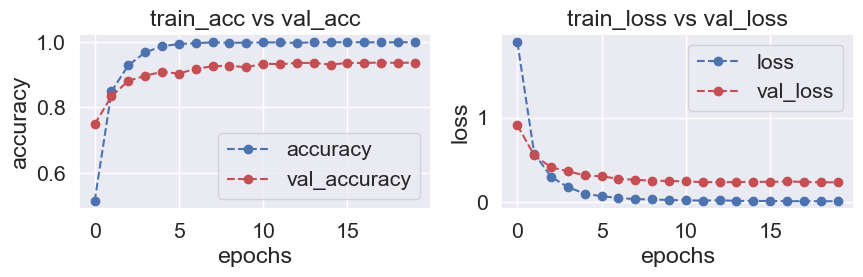

In [19]:
plot_accuracy_loss(history)

In [20]:
test_loss = model.evaluate(test_images, test_labels)

38/38 [==============================] - 32s 816ms/step - loss: 0.3134 - accuracy: 0.9159


38/38 [==============================] - 33s 827ms/step


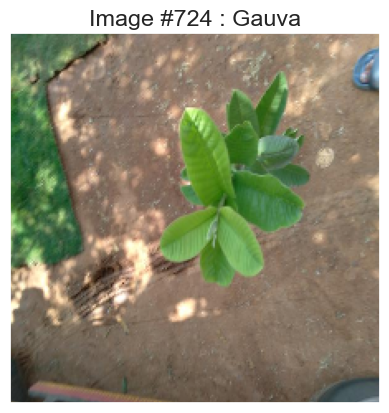

In [21]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [22]:
model.save_weights("model_weights.h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Save as a single HDF5 file
model.save("model.h5")
# model = tf.keras.models.load_model("model.h5")

class_names = list(class_names_label.keys())

def preprocess_single_image(image_path):
    IMAGE_SIZE = (224, 224)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    img_norm = img.astype('float32') / 255.0
    img_norm = np.expand_dims(img_norm, axis=0)
    return img, img_norm


def predict_and_display_image(image_path):
    img, img_norm = preprocess_single_image(image_path)
    predictions = model.predict(img_norm)
    predicted_class = np.argmax(predictions, axis=1)[0]
    print(predicted_class)
    class_label = class_names[predicted_class]
    confidence = np.max(predictions) * 100

   
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_label}\nConfidence: {confidence:.2f}%", fontsize=14, fontweight="bold")
    plt.show()




In [24]:
#predicted_class